In [1]:
from textwrap import wrap
import json

from dotenv import dotenv_values
import openai
openai.api_key = dotenv_values(".env")["OPENAI_API_KEY"]

from matplotlib import pyplot as plt
import numpy as np

In [2]:
PROMPT= """

1.  Describe a scenario that might produce a time series. This scenario should be detailed 
    and include external events and how they might influence the reading.
    Describe these events and where they occur in the time series.
    Delimit this description with the XML tag <description>.  
    
    Also add a summary of the description, no more than 25 words in length with the tag 
    <description_short>. 
    
    Also add a summary, no more than three words in length with the tag <description_tiny>.
    
    The scenario should be as different as possible from any of the following : [<previous_descriptions>]

2.  You will generate a list of up to five characteristics of this specific time series, 
    including patterns that you might expect to see in the series and how external events 
    might cause distribution shifts in the data generating process. Delimit these characteristics
    with the XML tag  <characteristics>.

3.  You will write a numpy  function called `generate_series`  that takes no arguments and
    outputs a time series that matches the description. 
    All parameters from the data generating process should be drawn from reasonable 
    distributions. The function must return a single numpy array. 
    The time series must be less than 1000 observations in length. Place this code inside
    a python markdown block and delimit your code with the XML tag <generator>. Do not call the function, simply define it.

    It will look like this:

    

4   Return a json string, delimited by the tag <metadata> that contains the units of 
    the time series and the timestamps corresponding to the first and last values.
    Remember that in JSON format datetimes must be passed as strings.
    The string would look like this (with the appropriate values for x, y, and z). Do not format this as markdown.:

        {
        "start": x,
        "end": y,
        "units": z
        } 

Here is an example of a complete response: 
<description> *your description* </description> 
<description_short> *your description* </description_short>
<description_tiny> *your description* </description_tiny>
<characteristics> *your characteristics* </characteristics>
<generator> 
    ```python
    def generate_series():
        # your code here
        return x
    ```
</generator>
<metadata>        
        {
        "start": x,
        "end": y,
        "units": z
        } 
</metadata>
"""

In [3]:
response = openai.ChatCompletion.create(
  model="gpt-3.5-turbo",
  messages=[
    {
      "role": "system",
      "content": PROMPT
    },
  ],
  temperature=1,
  max_tokens=4000,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0
)


In [3]:
def parse_response_for_xml_contents(response, *tags):
    xml_contents = {}
    for tag in tags:
        xml_contents[tag] = response.choices[0]["message"]["content"].split(f"<{tag}>")[1].split(f"</{tag}>")[0]
    return xml_contents

In [37]:
RESPONSE_TAGS = [
    "description",
    "description_short",
    "description_tiny",
    "characteristics",
    "generator",
    "metadata",
]


def call_generated_function(fn_code,fn_name):
    fn_dict = {}
    exec(fn_code,fn_dict)
    return fn_dict[fn_name]()

In [38]:
n_series = 1

def call_generated_function(fn_code,fn_name):
    fn_dict = {}
    exec(fn_code,fn_dict)
    return fn_dict[fn_name]()

def generate_ts(n_series, model = "gpt-4"):
    results = []
    i = 0
    while i < n_series:
        formatted_previous = ", ".join([r["description_short"] for r in results[-20:]])
        formatted_prompt = PROMPT.replace("<previous_descriptions>", formatted_previous)
        response = openai.ChatCompletion.create(
                    model=model,
                    messages=[
                        {
                        "role": "system",
                        "content": formatted_prompt
                        },
                    ],
                    temperature=1,
                    max_tokens=3000,
                    top_p=1,
                    frequency_penalty=0,
                    presence_penalty=0
                    )
        
        # print(response.choices[0]["message"]["content"])
        try:
            resp = parse_response_for_xml_contents(response, *RESPONSE_TAGS)
            resp["metadata"] = json.loads(resp["metadata"])
        except (KeyError, json.decoder.JSONDecodeError, IndexError) as e:
            print("Failed to parse response")
            continue
        
        # Sketchy!!
    
        code = resp["generator"].replace("```python", "").replace("```", "")
        resp["generator"] = code
        
        series = call_generated_function(code, "generate_series")
        # except Exception as e:
        #     print("Failed to generate series")
        #     print(e)
        #     continue
    
        resp["series"] = series
        results.append(resp)
        i += 1

    return results

generate_ts(1)

[{'description': "\nImagine a multiplex cinema that offers various shows every day. We want to track the sales of popcorn over time. This produces a time series where the data point at a given time represents the amount of popcorn sold that day.\n\nThere are a few external events that could influence popcorn sales. For instance, blockbuster movie releases, which occur irregularly throughout the year, could boost popcorn sales as more people visit the cinema. School holidays would also probably see more popcorn sales due to increased attendance from students. These events would create peaks in the time series. \n\nOn the other hand, there could be days when the cinema is closed for renovation or due to power failure. These events would result in a drop to zero in popcorn sales on those specific days. Similarly, social events like a big football game could reduce the number of cinema-goers and thereby popcorn sales, causing a trough in the time series.\n\nOverall, we would see an oscilla

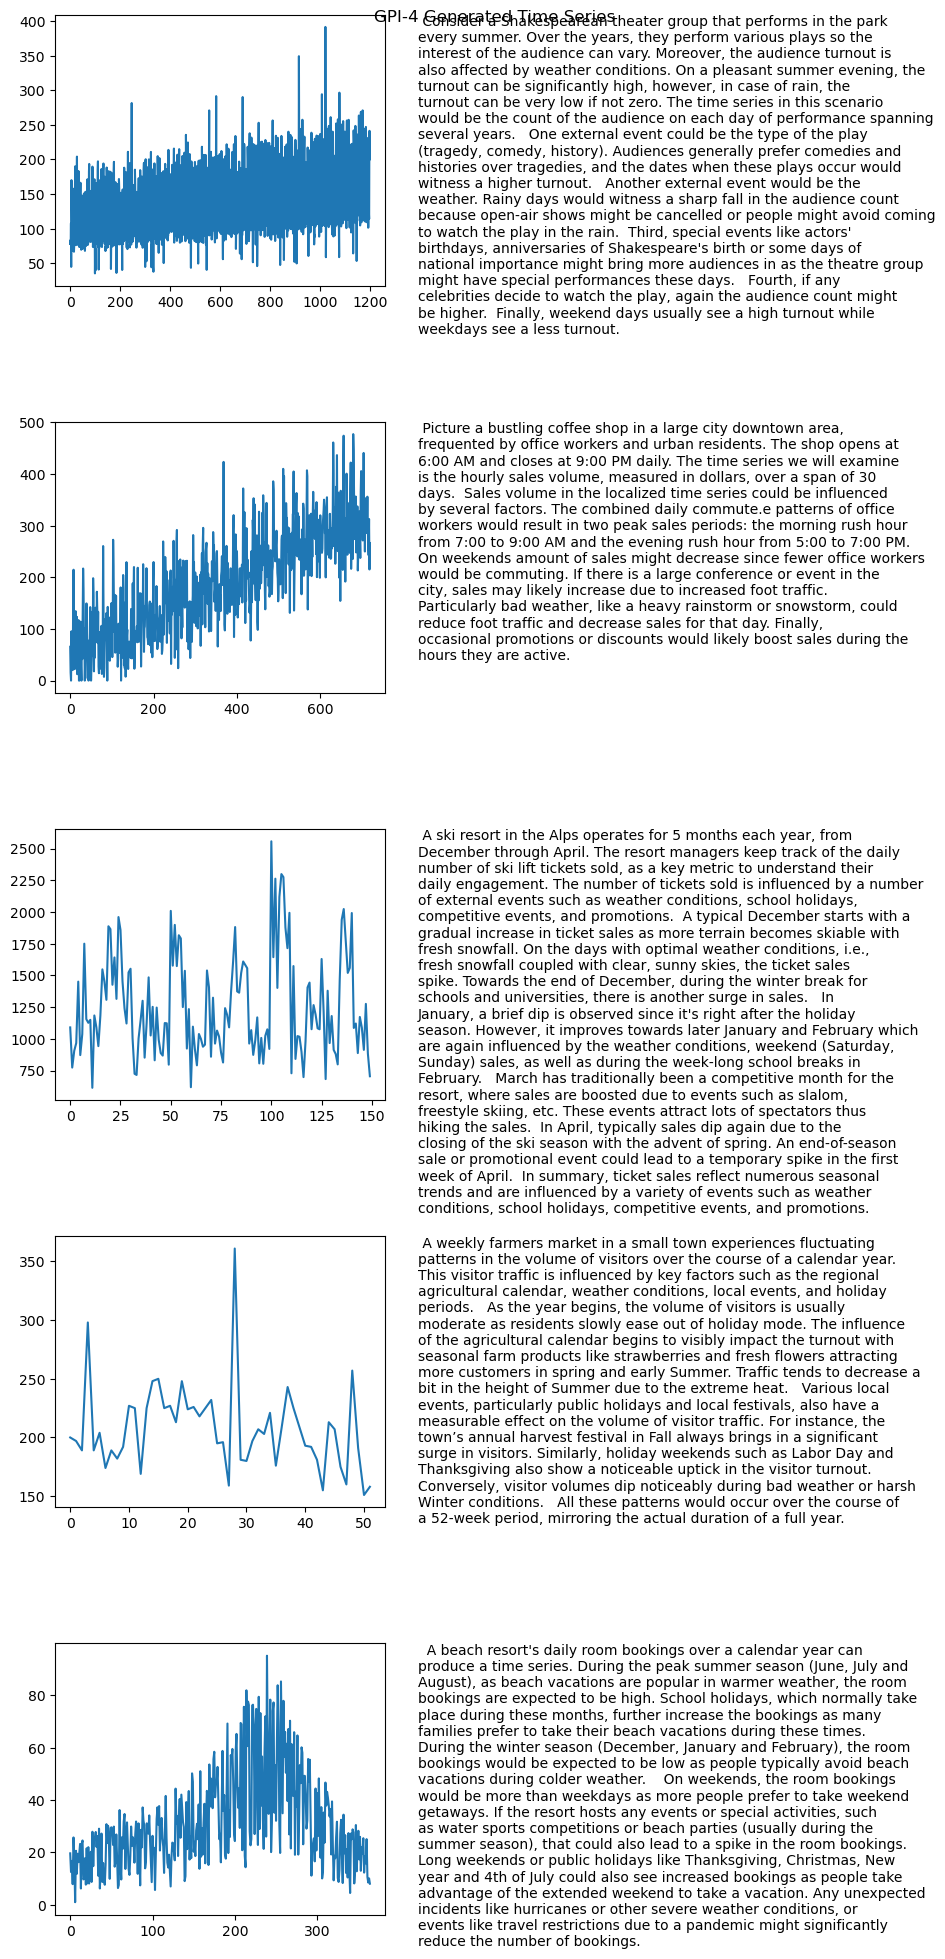

In [49]:
results = generate_ts(n_series)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
for i, result in enumerate(results[-5:]):
    axs[i].plot(result["series"])
    axs[i].text(1.1, 1, "\n".join(wrap(result["description"])), transform=axs[i].transAxes, verticalalignment='top')
    # axs[i].set_xticks([])
    # axs[i].set_yticks([])
plt.suptitle("GPI-4 Generated Time Series")
plt.tight_layout()



In [28]:
gpt_35_results = generate_ts(n_series, model="gpt-3.5-turbo")




import numpy as np

def generate_series():
    start_date = np.datetime64('2022-01-01')
    end_date = np.datetime64('2022-12-31')
    num_days = (end_date - start_date).astype(int) + 1
    
    # Generate random daily temperature readings
    temperature = np.random.normal(loc=65, scale=10, size=num_days)
    
    return temperature




import numpy as np

def generate_series():
    start_date = np.datetime64('2020-01-01')
    end_date = np.datetime64('2021-12-31')
    num_days = (end_date - start_date).astype(int)

    # Generate random stock prices
    prices = np.random.uniform(low=50, high=150, size=num_days)

    # Simulate external events
    num_events = np.random.poisson(10)
    event_dates = np.random.choice(np.arange(num_days), size=num_events, replace=False)
    event_magnitudes = np.random.normal(loc=0, scale=10, size=num_events)

    for i, event_date in enumerate(event_dates):
        prices[event_date:] += event_magnitudes[i]

    return prices




import numpy as np

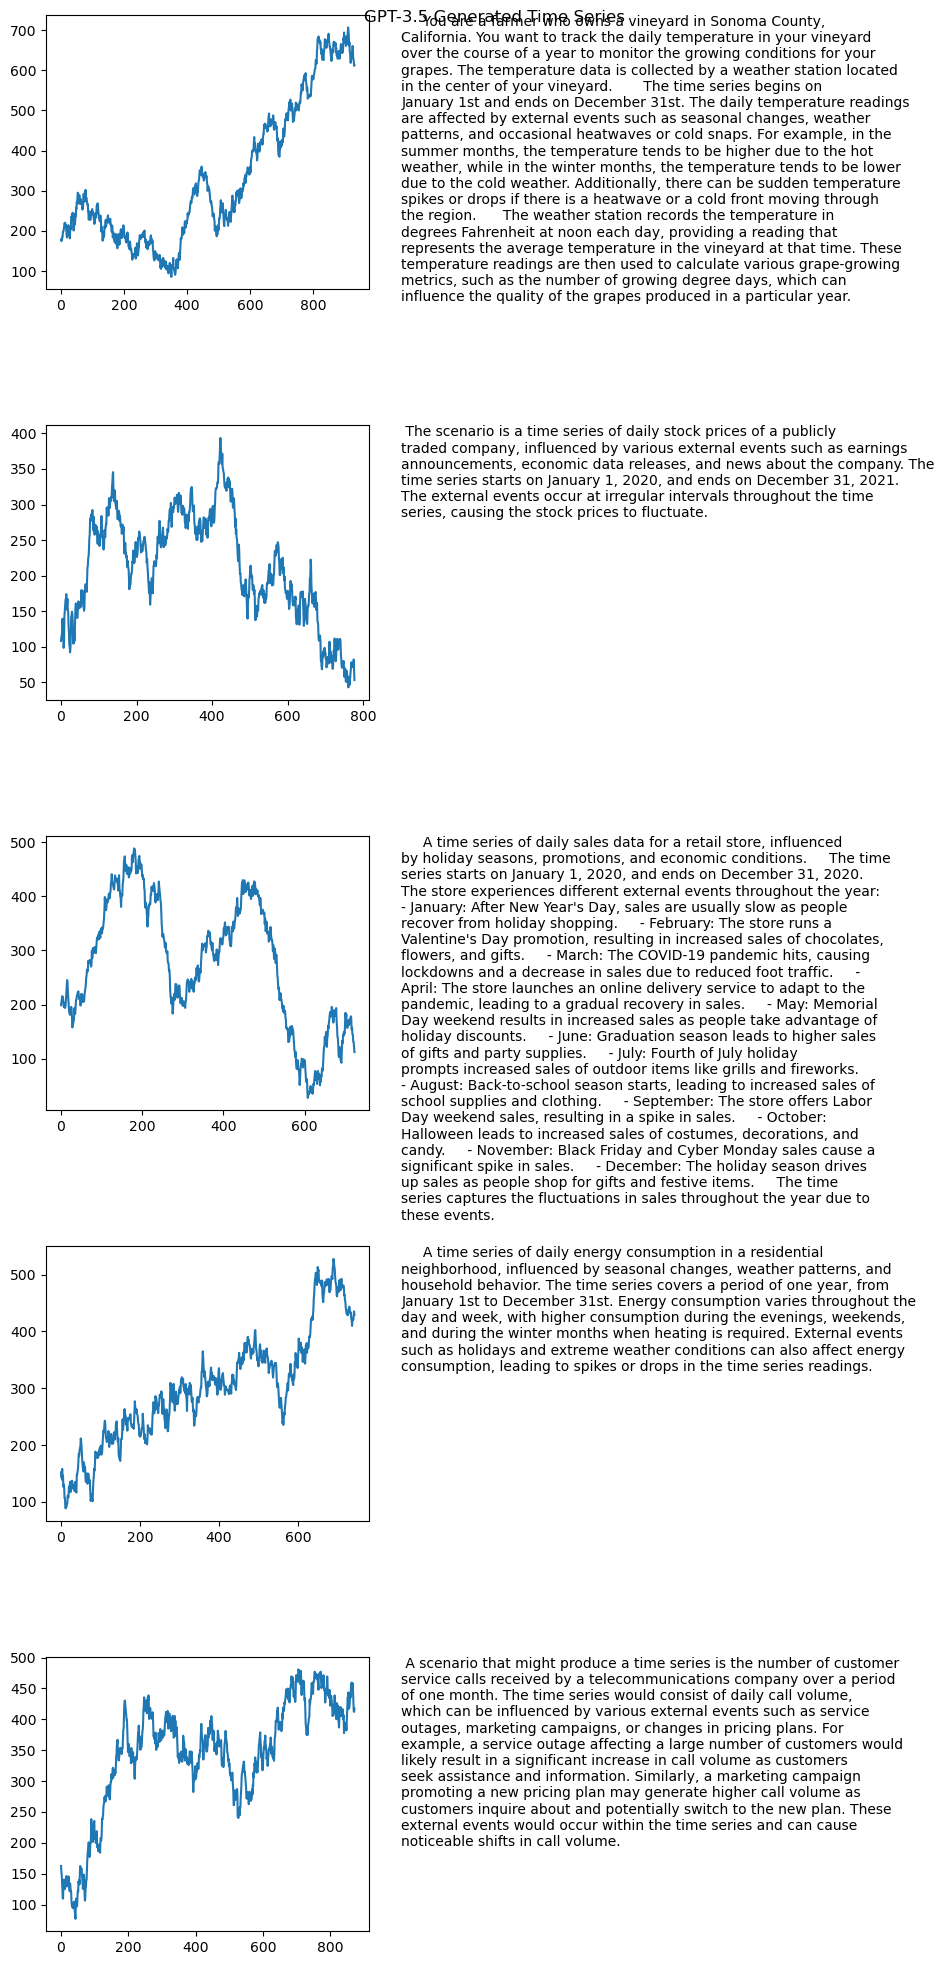

In [29]:
fig, axs = plt.subplots(5, 1, figsize=(10, 20))
for i, result in enumerate(gpt_35_results[-5:]):
    axs[i].plot(result["series"])
    axs[i].text(1.1, 1, "\n".join(wrap(result["description"])), transform=axs[i].transAxes, verticalalignment='top')
    # axs[i].set_xticks([])
    # axs[i].set_yticks([])
plt.suptitle("GPT-3.5 Generated Time Series")
plt.tight_layout()


[{'description': "\nConsider a Shakespearean theater group that performs in the park every summer. Over the years, they perform various plays so the interest of the audience can vary. Moreover, the audience turnout is also affected by weather conditions. On a pleasant summer evening, the turnout can be significantly high, however, in case of rain, the turnout can be very low if not zero. The time series in this scenario would be the count of the audience on each day of performance spanning several years. \n\nOne external event could be the type of the play (tragedy, comedy, history). Audiences generally prefer comedies and histories over tragedies, and the dates when these plays occur would witness a higher turnout. \n\nAnother external event would be the weather. Rainy days would witness a sharp fall in the audience count because open-air shows might be cancelled or people might avoid coming to watch the play in the rain.\n\nThird, special events like actors' birthdays, anniversaries 

In [23]:
exec(
    """
import numpy as np
from scipy import stats

def generate_series():
    # Generate series with trend, seasonality, and noise
    np.random.seed(0)
    trend = np.linspace(4000, 7000, 60)  # Upward trend over 5 years
    noise = np.random.normal(0, 300, 60)  # Random noise

    # Seasonality with peaks in summer (festival), Easter, and Christmas
    seasonality = np.tile(
        [1000, 1000, 0, 1000, 0, 8000, 8000, 8000, 0, 0, 0, 2000], 5
    )

    # Severe weather event in third year reduces revenue
    event = np.zeros(60)
    event[24:27] = -4000

    return trend + noise + seasonality + event
    """
)


In [21]:
del generate_series

In [24]:
generate_series()

array([ 5529.21570379,  5170.89462014,  4395.31631049,  5824.81033264,
        4763.65722755, 11961.05392417, 12590.11127102, 12310.5250409 ,
        4375.81400548,  4580.80666923,  4551.68764762,  6995.60408599,
        5838.48080907,  5697.5194541 ,  4845.0233766 ,  5862.81416262,
        5261.78304398, 12802.85930053, 13009.17454778, 12709.87297312,
        4251.05220779,  5263.8821888 ,  5377.97492745,  6946.8420193 ,
        2901.26537025,  1834.8767383 ,  1335.7614535 ,  6316.72620092,
        5883.56257787, 13915.38390216, 13571.90795652, 13689.71994232,
        5360.78291978,  5083.72716123,  5624.43991452,  7826.56570768,
        7199.59567879,  7242.06988684,  5816.00534461,  6892.36002229,
        5719.33241556, 13658.74038156, 13623.71216315, 14771.67329654,
        6084.39248107,  6156.71330274,  5963.14444283,  8623.07761522,
        6956.50861183,  7427.70333966,  6273.732913  ,  7709.29108834,
        6490.82625534, 14340.725599  , 14737.30804336, 14925.10973065,
      